# Model F

This is a script showing results of **model F** in the ablation studies. The model is built using the following configuration:

- **Backbone:** Transformer
- **Graph type:** Homogeneous
- **Loss function:** Binary-Cross Entropy with Logits Loss
- **Embeddings used:** Yes
- **Research trends used:** No
- **Lead author flag used:** No

*This model introduces a baseline loss function Binary-Cross Entropy with Logits loss to compare against Bayesian Personalized Ranking on graph transformer backbone.*

## **Setting up environment**

---



### Loading libraries

In [15]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))

import torch
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional

from torch import Tensor
from torch.nn import ModuleList
import torch.nn.functional as F
from torch.optim import Optimizer
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.nn.conv import TransformerConv
from torch.optim.lr_scheduler import LRScheduler

from util.homogeneous.dataset import DatasetEuCoHM
from util.homogeneous.model import ModelEuCoHM
from util.homogeneous.train import (
    train,
    test,
    evaluate,
    get_results
)

### Global variables

In [7]:
# Model name
model_name = 'E'
# Dataset save filepath
dataset_save_filepath = '../data/dataset_homogeneous.pkl'
# Device name
device = 'cpu'

# Model configuration
model_config = dict(
    hidden_channels=64,
    learning_rate=1e-3,
    num_layers=4,
    num_heads=2,
    num_epochs=50,
    num_recommendations=10
)
# Set seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

## Loading dataset

---


In [8]:
# Add the object as a safe global to shut down warning
torch.serialization.add_safe_globals([DatasetEuCoHM])
# Open the dataset file and save it to variable
with open(dataset_save_filepath, 'rb') as file:
    dataset: DatasetEuCoHM = pickle.load(file)

data = dataset.data
author_id_map = dataset.author_id_map
author_node_id_map = dataset.author_node_id_map

## Model training


---



### Model definition

In [9]:
class ModelEuCoE(ModelEuCoHM):
    def __init__(self,
                 input_channels: int,
                 hidden_channels: int,
                 num_layers: int,
                 num_recommendations: int,
                 num_heads: int,
                 author_node_id_map: dict,
                 author_id_map: dict,
                 device: str = 'cpu'):
        super().__init__(
            input_channels=input_channels,
            hidden_channels=hidden_channels,
            num_layers=num_layers,
            num_recommendations=num_recommendations,
            author_node_id_map=author_node_id_map,
            author_id_map=author_id_map,
            device=device
        )
        # Set number of attention heads
        self.num_heads = num_heads

        # Initialize the convolutional layers
        self.conv_layers = ModuleList([
            TransformerConv(in_channels=input_channels if ix == 0 else hidden_channels * self.num_heads, 
                            out_channels=hidden_channels,
                            heads=self.num_heads)
            for ix in range(self.num_layers)
        ])

        # Initialize batch norm layers
        self.bn_layers = ModuleList([
            torch.nn.BatchNorm1d(hidden_channels * self.num_heads)
            for ix in range(self.num_layers)
        ])
    
    def recommendation_loss(self,
                            x: Tensor,
                            edge_index: Adj,
                            pos_edge_rank: Tensor,
                            neg_edge_rank: Tensor,
                            node_id: Optional[Tensor] = None) -> Tensor:

        # Construct labels
        pos_labels = pos_edge_rank.new_ones(pos_edge_rank.size(0))
        neg_labels = neg_edge_rank.new_zeros(neg_edge_rank.size(0))

        # Concatenate predictions and labels
        all_preds = torch.cat([pos_edge_rank, neg_edge_rank], dim=0)
        all_labels = torch.cat([pos_labels, neg_labels], dim=0)

        # Compute BCE loss
        bce_loss = F.binary_cross_entropy_with_logits(all_preds, all_labels)

        return bce_loss

### Training the model

In [10]:
# Initialize the model
model = ModelEuCoE(
    input_channels=data.num_features,
    hidden_channels=model_config['hidden_channels'],
    num_recommendations=model_config['num_recommendations'],
    num_layers=model_config['num_layers'],
    num_heads=model_config['num_heads'],
    author_node_id_map=author_node_id_map,
    author_id_map=author_id_map
).to(device)

# Transfer to device
data = data.to(device)

# Initialize the optimizer
optimizer: Optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=model_config['learning_rate']
)

# Initialize the scheduler
scheduler: LRScheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    factor=0.5,
    patience=10
)

In [11]:
results: list = list()
for epoch in range(1, model_config['num_epochs'] + 1):
    # ------ Train
    train_loss: float = train(
        model=model,
        data=data,
        optimizer=optimizer
    )
    # ------ Test
    test_loss: float = test(
        model=model,
        data=data
    )
    scheduler.step(test_loss)
    # ------ Evaluate
    evaluation_results: dict = evaluate(
        k=model_config['num_recommendations'],
        model=model,
        data=data
    )

    # Save results
    epoch_result = get_results(
        epoch=epoch,
        train_loss=train_loss,
        test_loss=test_loss,
        evaluation_results=evaluation_results
    )
    results.append(epoch_result)

Epoch 1, train loss: 0.9114, test loss: 0.4965, precision@k: 0.0910, recall@k: 0.1757, MAP@k: 0.1091, MRR@k: 0.1721, NDCG@k: 0.1514, HitRate@k: 0.3202
Epoch 2, train loss: 1.0688, test loss: 0.4607, precision@k: 0.0961, recall@k: 0.1882, MAP@k: 0.1168, MRR@k: 0.1863, NDCG@k: 0.1622, HitRate@k: 0.3441
Epoch 3, train loss: 0.7232, test loss: 0.4553, precision@k: 0.0944, recall@k: 0.1837, MAP@k: 0.1144, MRR@k: 0.1839, NDCG@k: 0.1588, HitRate@k: 0.3389
Epoch 4, train loss: 0.6115, test loss: 0.4537, precision@k: 0.0942, recall@k: 0.1822, MAP@k: 0.1134, MRR@k: 0.1828, NDCG@k: 0.1578, HitRate@k: 0.3370
Epoch 5, train loss: 0.5536, test loss: 0.4526, precision@k: 0.0941, recall@k: 0.1810, MAP@k: 0.1136, MRR@k: 0.1845, NDCG@k: 0.1579, HitRate@k: 0.3359
Epoch 6, train loss: 0.5116, test loss: 0.4534, precision@k: 0.0932, recall@k: 0.1785, MAP@k: 0.1126, MRR@k: 0.1830, NDCG@k: 0.1562, HitRate@k: 0.3298
Epoch 7, train loss: 0.4797, test loss: 0.4558, precision@k: 0.0916, recall@k: 0.1749, MAP@k: 

### Model evaluation

In [12]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'../results/results_Model{model_name}.csv', index=False)

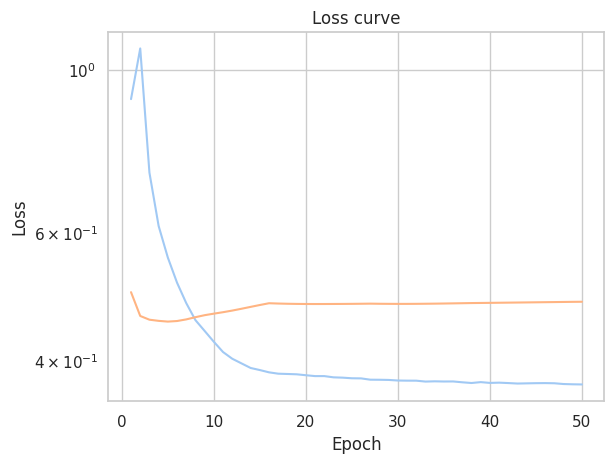

In [13]:
# Generate loss curve
# Train loss
sns.lineplot(data=results_df, x='Epoch', y='Train Loss')
# Test loss
sns.lineplot(data=results_df, x='Epoch', y='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.yscale('log')
plt.show()

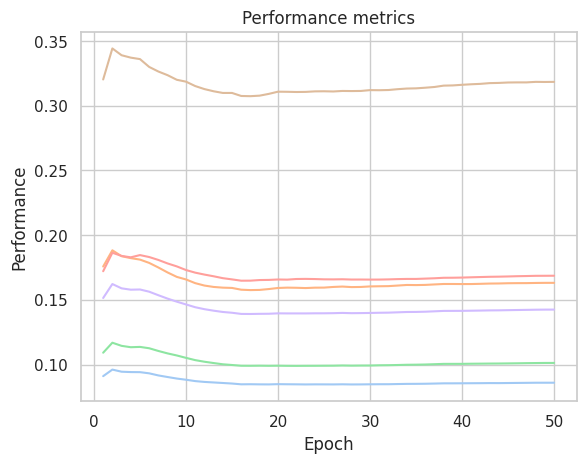

In [14]:
# Generate evaluation metrics plot
sns.lineplot(data=results_df, x='Epoch', y='Precision@k')
sns.lineplot(data=results_df, x='Epoch', y='Recall@k')
sns.lineplot(data=results_df, x='Epoch', y='MAP@k')
sns.lineplot(data=results_df, x='Epoch', y='MRR@k')
sns.lineplot(data=results_df, x='Epoch', y='NDCG@k')
sns.lineplot(data=results_df, x='Epoch', y='HitRate@k')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.title('Performance metrics')
plt.show()